In [22]:
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [23]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

In [24]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super().__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        n = len(state)
        
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action

        # Update velocity
        state = state + delta_state + delta_state_gravity
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [25]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [26]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super().__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1., 0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2

In [45]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            if epoch == epochs-1:
                self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        actions = np.array([self.simulation.action_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        fig = plt.figure()
        ax1 = fig.add_subplot(211)
        ax1.set_ylabel("distance (d)")
        ax1.plot(x)

        ax2 = fig.add_subplot(212)
        ax2.set_ylabel('velocity')
        ax2.plot(y)
        plt.show()

        plt.plot(actions)
        plt.show()
        # plt.plot(x, y)
        # plt.show()

[1] loss: 2.970
[2] loss: 1.509
[3] loss: 0.836
[4] loss: 0.463
[5] loss: 0.253
[6] loss: 0.150
[7] loss: 0.099
[8] loss: 0.072
[9] loss: 0.057
[10] loss: 0.048
[11] loss: 0.042
[12] loss: 0.039
[13] loss: 0.037
[14] loss: 0.036
[15] loss: 0.035
[16] loss: 0.035
[17] loss: 0.034
[18] loss: 0.033
[19] loss: 0.030
[20] loss: 0.012
[21] loss: 0.005
[22] loss: 0.002
[23] loss: 0.001
[24] loss: 0.000
[25] loss: 0.000
[26] loss: 0.000
[27] loss: 0.000
[28] loss: 0.000
[29] loss: 0.000
[30] loss: 0.000
[31] loss: 0.000
[32] loss: 0.000
[33] loss: 0.000
[34] loss: 0.000
[35] loss: 0.000
[36] loss: 0.000
[37] loss: 0.000
[38] loss: 0.000
[39] loss: 0.000
[40] loss: 0.000


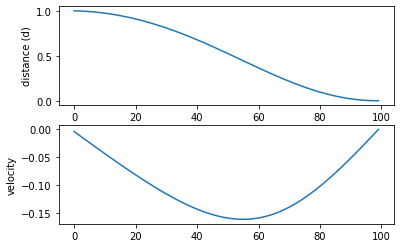

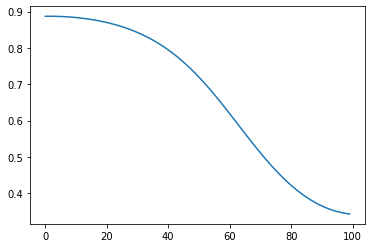

In [47]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem


In [58]:
# x = t.ones(4,2,2)
# y = t.tensor([[[1,2,3],[4,5,6]],[[2,2,2],[3,3,3]],[[4,4,4],[4,4,4]]])
x = t.rand(5,2,3)
y = t.rand(3).reshape(3,1)
l = 2
h = 10
x = (l-h)*x+h
# print(x-x.transpose(1,2))
# print(y,y.shape)
# display(t.matmul(x,y))
# display(t.matmul(x,y).shape)
# x.transpose(1,2)
# y
# t.vstack(y)

c.forward(s.state)#[0].reshape(-1,1)
# actions = np.array([-s.action_trajectory[i].detach().numpy() for i in range(s.T)])
# plt.plot(actions)
# plt.show()

tensor([0.8871], grad_fn=<SigmoidBackward0>)